In [1]:
#Import Packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import rioxarray as rx
from rioxarray.merge import merge_arrays

In [4]:
# geodataframe
balt_bg = gpd.read_file("model_inputs/bg_baltimore.csv", 
                        GEOM_POSSIBLE_NAMES="geometry",
                        KEEP_GEOM_COLUMNS="NO")

balt_bg = balt_bg.set_crs('epsg:3857')
bg_visual = balt_bg.to_crs('epsg:4269')


<Axes: >

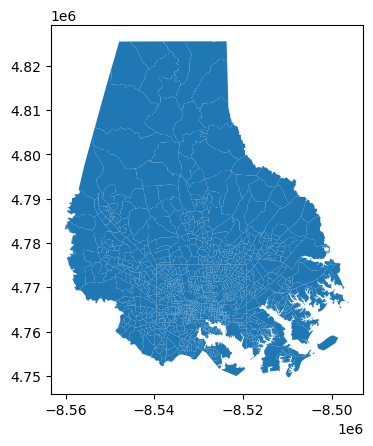

In [5]:
#visualize geodataframe
balt_bg.plot()

In [6]:
#open tif file
raster_base = rx.open_rasterio("flood_inputs/FastFlood/Base/Surge-BaltimoreBase-10m_27.tif")
raster_levee = rx.open_rasterio("flood_inputs/FastFlood/Levee/Surge-BaltimoreAll-10m_27.tif")

rasters = [raster_base, raster_levee]
#raster.rio.crs
#combine rasters
#ds_grid = [[raster_base, raster_levee], [raster_base, raster_levee]]
#xr.combine_nested(ds_grid,concat_dim=["x","y"])


<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

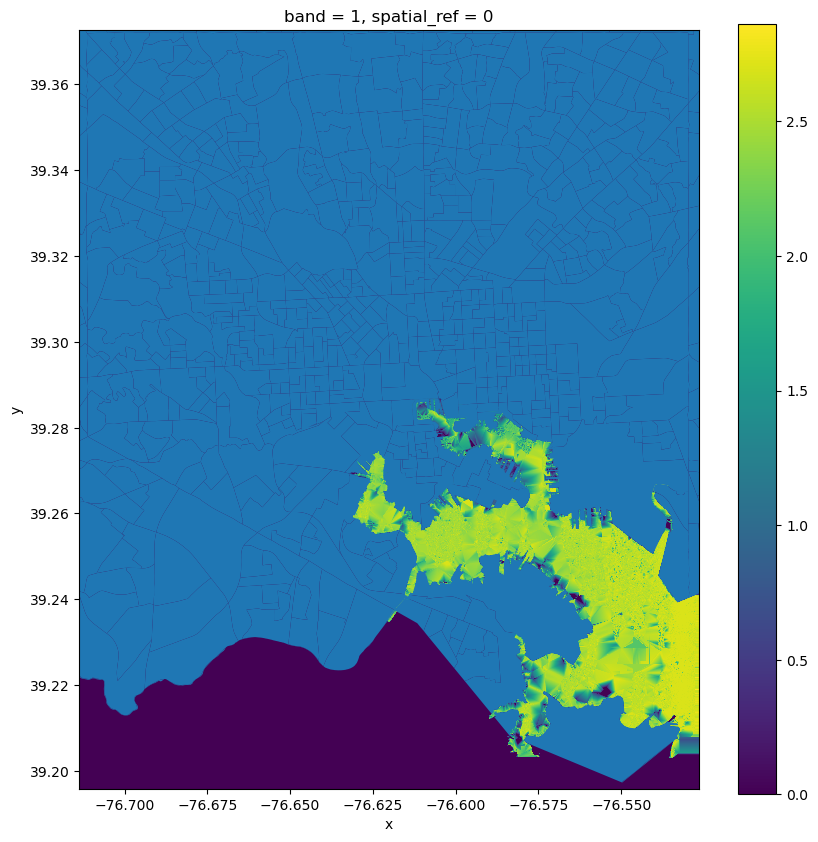

In [7]:

f, ax = plt.subplots(1, figsize=(10, 10))
raster_base.plot(ax=ax)
bg_visual.plot(ax=ax)

In [9]:

band = rasters[0][0]
x, y, extent = band.x.values, band.y.values, band.values
x, y = np.meshgrid(x, y)
x, y, extent = x.flatten(), y.flatten(), extent.flatten()

#Convert to point geometries 
centroids = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_xy(x, y, crs=band.rio.crs))
centroids['base'] = extent

#band_list = [[]for i in range(len(rasters[1:]))]
band_dict = {}
for ras in rasters[1:]:
    #get first band of raster
    band = ras[0]
    extent = band.values.flatten()

    ##add to list
    #need to figure out better naming sequence
    band_dict['levee'] = extent

band_df = pd.DataFrame.from_dict(band_dict)
centroids = pd.concat([centroids, band_df], axis = 1)

    
    


In [10]:
centroids

,geometry,base,levee
0,POINT (-76.71369 39.37270),0.0,0.0
1,POINT (-76.71366 39.37270),0.0,0.0
2,POINT (-76.71363 39.37270),0.0,0.0
3,POINT (-76.71360 39.37270),0.0,0.0
4,POINT (-76.71356 39.37270),0.0,0.0
...,...,...,...
34770307,POINT (-76.52662 39.19582),0.0,0.0
34770308,POINT (-76.52659 39.19582),0.0,0.0
34770309,POINT (-76.52656 39.19582),0.0,0.0
34770310,POINT (-76.52653 39.19582),0.0,0.0


In [11]:
#join centroid geometries with block group geometries
bg_flood_area = gpd.sjoin(bg_visual,centroids)



In [12]:
#determine whether max flood depth occurrence within each block group
bg_flood_max = bg_flood_area[["GISJOIN","base","levee"]].groupby('GISJOIN').max()
#bg_flood_max = bg_flood_max.round({'extent':0})

#Rejoin block group geometries
balt_flood = bg_visual[["GISJOIN","geometry"]].merge(bg_flood_max, on='GISJOIN')

<Axes: >

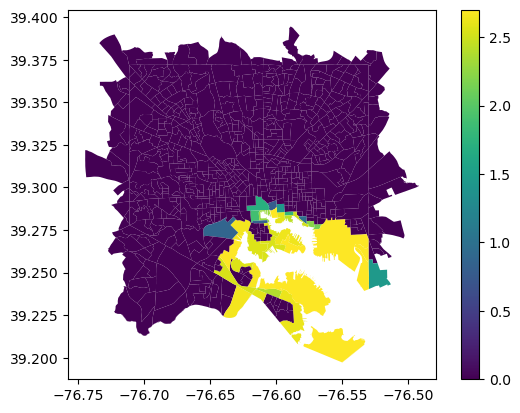

In [13]:
balt_flood.plot(column = 'base',legend=True)

<Axes: >

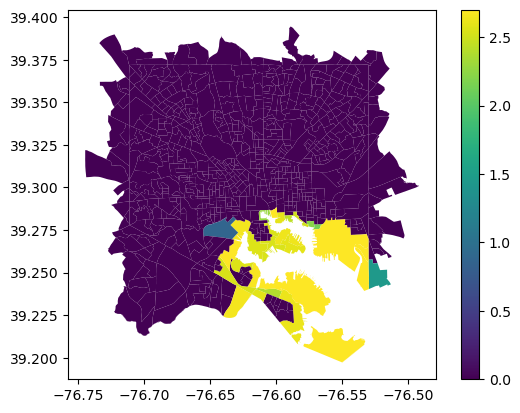

In [14]:
balt_flood.plot(column = 'levee',legend=True)

In [41]:
raster

<xarray.DataArray (band: 1, y: 5732, x: 6066)>
[34770312 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -76.71 -76.71 -76.71 ... -76.53 -76.53 -76.53
  * y            (y) float64 39.37 39.37 39.37 39.37 ... 39.2 39.2 39.2 39.2
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0.0
    scale_factor:   1.0
    add_offset:     0.0